# Motorization Rate in France

## Goals

**Predict the car equipment rate at the municipality level using the second dataset** 

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import shap

%matplotlib inline

In [5]:
df_TM = pd.read_excel('data/Taux_de_motorisation_a_lIRIS-Global_Map_Solution.xlsx')
df_TM.head()

,Code IRIS,Nom IRIS,Code Commune,Nom Commune,Taux de motorisation IRIS,Taux de motorisation Commune,Taux de motorisation Département
0,010010000,L'Abergement-Clémenciat,01001,L'Abergement-Clémenciat,0.963576,0.963576,0.903721
1,010020000,L'Abergement-de-Varey,01002,L'Abergement-de-Varey,0.950495,0.950495,0.903721
2,010040101,Ambérieu-en-Bugey / Les Perouses-Triangle d'Ac...,01004,Ambérieu-en-Bugey,0.781567,0.854474,0.903721
3,010040102,Ambérieu-en-Bugey / Longeray-Gare,01004,Ambérieu-en-Bugey,0.816198,0.854474,0.903721
4,010040201,Ambérieu-en-Bugey / Centre-St Germain-Vareilles,01004,Ambérieu-en-Bugey,0.816397,0.854474,0.903721


We will just keep our target and the code of each Commune

In [6]:
df_TM[['Code Commune', 'Taux de motorisation Commune']]

,Code Commune,Taux de motorisation Commune
0,01001,0.963576
1,01002,0.950495
2,01004,0.854474
3,01004,0.854474
4,01004,0.854474
5,01004,0.854474
6,01005,0.954693
7,01006,0.886792
8,01007,0.935798
9,01008,0.954545


We now access the dataset with a lot of features concerning Commune but also whole Departments

In [7]:
df_mdb = pd.read_excel('data/MDB-INSEE-V2.xls')
df_mdb.head()

WARNING *** file size (57125979) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,...,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,0.0,57.0,23.0,114,Bassin Industriel,101.93878,59.04139,0.00000,0.00000,...,0.01585,32.42578,33.83811,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,0.0,45.0,4.0,143,Bassin Résidentiel,101.93878,59.04139,0.00000,0.00000,...,0.00173,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
2,01004,0.0,634.0,828.0,366,Bassin Résidentiel,101.93878,59.04139,248.45549,0.10621,...,0.38471,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,01
3,01005,0.0,113.0,62.0,132,Bassin Urbain,101.93878,59.04139,248.45549,0.10621,...,0.02824,32.42578,33.83811,Bassin Urbain en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Moyenne dynamique,Faible Dynamique Serv et Com,01
4,01006,0.0,42.0,1.0,121,Bassin Résidentiel,101.93878,59.04139,0.00000,0.00000,...,0.00000,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01


In [8]:
#df_mdb.columns.tolist()
print('\n'.join(map(str, df_mdb.columns)))

CODGEO
Nb Pharmacies et parfumerie
Dynamique Entrepreneuriale
Dynamique Entrepreneuriale Service et Commerce
Synergie Médicale COMMUNE
Orientation Economique
Indice Fiscal Partiel
Score Fiscal
Indice Evasion Client
Score Evasion Client
Indice Synergie Médicale
Score Synergie Médicale
SEG Croissance POP
LIBGEO
REG
DEP
Nb Omnipraticiens BV
Nb Infirmiers Libéraux BV
Nb dentistes Libéraux BV
Nb pharmaciens Libéraux BV
Densité Médicale BV
Score équipement de santé BV
Indice Démographique
Score Démographique
Indice Ménages
Score Ménages
Population
Evolution Population
Evolution Pop %
Nb Ménages
Nb Résidences Principales
Nb propriétaire
Nb Logement
Nb Résidences Secondaires
Nb Log Vacants
Nb Occupants Résidence Principale
Nb Femme
Nb Homme
Nb Mineurs
Nb Majeurs
Nb Etudiants
Nb Entreprises Secteur Services
Nb Entreprises Secteur Commerce
Nb Entreprises Secteur Construction
Nb Entreprises Secteur Industrie
Nb Création Enteprises
Nb Création Industrielles
Nb Création Construction
Nb Création Com

### Merge

In [9]:
df = df_TM[['Code Commune', 'Taux de motorisation Commune']].merge(right=df_mdb, left_on='Code Commune', right_on='CODGEO')
df.head()

,Code Commune,Taux de motorisation Commune,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Score Fiscal,...,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,0.963576,01001,0.0,57.0,23.0,114,Bassin Industriel,101.93878,59.04139,...,0.01585,32.42578,33.83811,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,0.950495,01002,0.0,45.0,4.0,143,Bassin Résidentiel,101.93878,59.04139,...,0.00173,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
2,01004,0.854474,01004,0.0,634.0,828.0,366,Bassin Résidentiel,101.93878,59.04139,...,0.38471,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,01
3,01004,0.854474,01004,0.0,634.0,828.0,366,Bassin Résidentiel,101.93878,59.04139,...,0.38471,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,01
4,01004,0.854474,01004,0.0,634.0,828.0,366,Bassin Résidentiel,101.93878,59.04139,...,0.38471,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,01


In [10]:
len(df_TM), len(df), df.duplicated().sum()

(50153, 48571, 12057)

In [11]:
df_mdb.duplicated().sum(), df_TM.duplicated().sum()

(0, 0)

In [12]:
df_mdb['CODGEO'].nunique()

36677

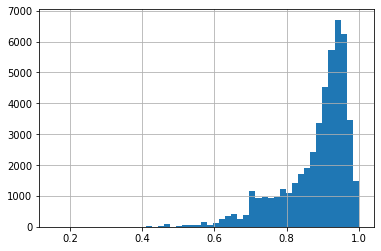

In [13]:
df['Taux de motorisation Commune'].hist(bins=50)

The overall motorization rate is pretty high, with the majority of Communes being aroung 90%

The **Urbanité Ruralité** feature looks interesting, lets explore it 

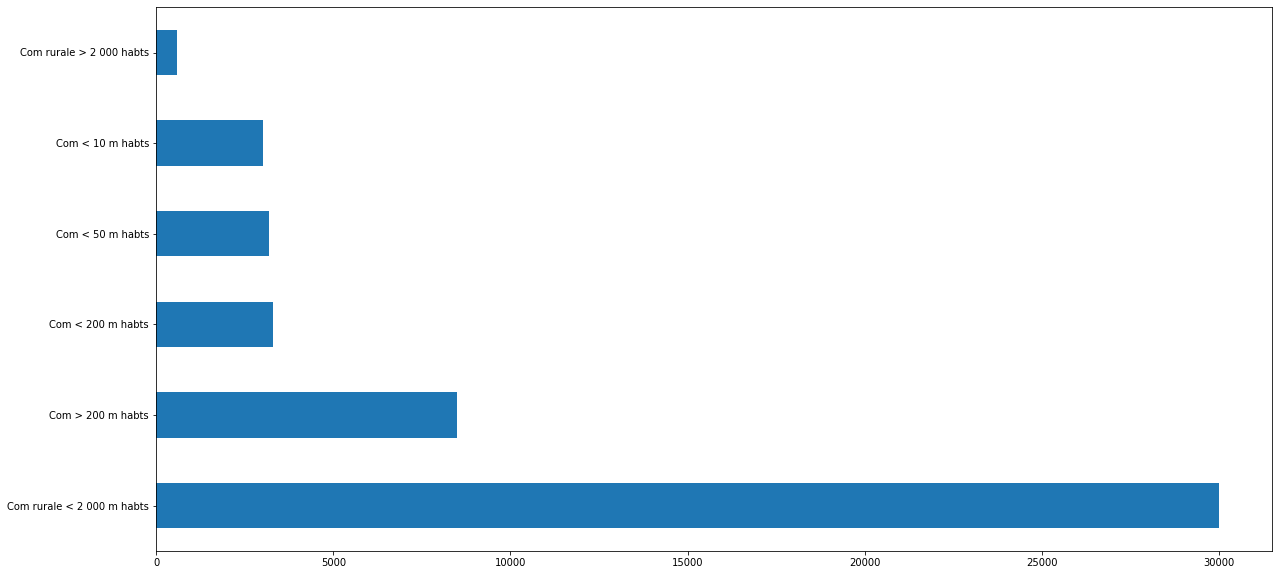

In [14]:
df['Urbanité Ruralité'].value_counts().plot(kind='barh', figsize=(20,10))

Needs transformation, the last category proabably contains the other ones, we surelay want to separate

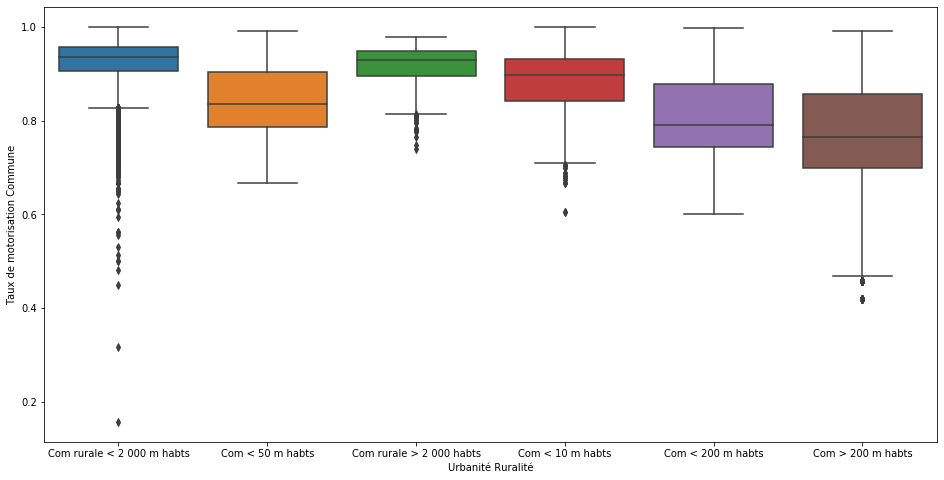

In [15]:
plt.figure(figsize=(16,8))
ax = sns.boxplot(x='Urbanité Ruralité', y='Taux de motorisation Commune', data=df)
#ax = sns.swarmplot(x='Urbanité Ruralité', y='Taux de motorisation Commune', data=df, color="grey")

Indeed, Com rurale < 2000 m habitants has a lot of outliers, because those should belong exclusively to other categories.

We can't just look at each feature and try to see with it's worth to keep, we better try to select a set of them which will provide a good prediction

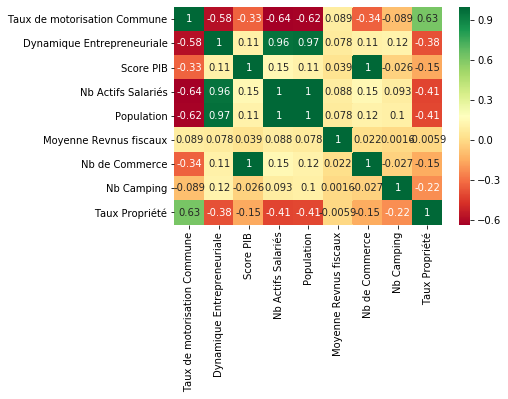

In [16]:
g = sns.heatmap(df[['Taux de motorisation Commune', 'Dynamique Entrepreneuriale', 'Score PIB', 'Nb Actifs Salariés', 'Population', 'Moyenne Revnus fiscaux', 'Nb de Commerce', 'Nb Camping', 'Taux Propriété']].corr(),annot=True,cmap="RdYlGn")

### Lot of features, which ones actually matter ?

#### We are going to try several feature selection methods and then compare wich features each methode would keep

In [17]:
num_cols = df._get_numeric_data().columns.tolist()
num_cols

['Taux de motorisation Commune',
 'Nb Pharmacies et parfumerie',
 'Dynamique Entrepreneuriale',
 'Dynamique Entrepreneuriale Service et Commerce',
 'Synergie Médicale COMMUNE',
 'Indice Fiscal Partiel',
 'Score Fiscal',
 'Indice Evasion Client',
 'Score Evasion Client',
 'Indice Synergie Médicale',
 'Score Synergie Médicale',
 'REG',
 'Nb Omnipraticiens BV',
 'Nb Infirmiers Libéraux BV',
 'Nb dentistes Libéraux BV',
 'Nb pharmaciens Libéraux BV',
 'Densité Médicale BV',
 'Score équipement de santé BV',
 'Indice Démographique',
 'Score Démographique',
 'Indice Ménages',
 'Score Ménages',
 'Population',
 'Evolution Population',
 'Evolution Pop %',
 'Nb Ménages',
 'Nb Résidences Principales',
 'Nb propriétaire',
 'Nb Logement',
 'Nb Résidences Secondaires',
 'Nb Log Vacants',
 'Nb Occupants Résidence Principale',
 'Nb Femme',
 'Nb Homme',
 'Nb Mineurs',
 'Nb Majeurs',
 'Nb Etudiants',
 'Nb Entreprises Secteur Services',
 'Nb Entreprises Secteur Commerce',
 'Nb Entreprises Secteur Construc

In [18]:
cols = df.columns.tolist()

In [19]:
cat_cols = [col for col in cols if col not in num_cols]
cat_cols

['Code Commune',
 'CODGEO',
 'Orientation Economique',
 'SEG Croissance POP',
 'LIBGEO',
 'DEP',
 'Urbanité Ruralité',
 'Dynamique Démographique BV',
 'SEG Environnement Démographique Obsolète',
 'Environnement Démographique',
 'Fidélité',
 'SYN MEDICAL',
 'Seg Cap Fiscale',
 'Seg Dyn Entre',
 'DYN SetC',
 'CP']

In [20]:
len(df.columns), len(num_cols), len(cat_cols)

(103, 87, 16)

In [21]:
df = df.drop(columns="CODGEO")

In [22]:
df.columns[df.isna().any()].tolist() # List columns which have at least one NA value

['Taux de motorisation Commune',
 'Nb Pharmacies et parfumerie',
 'Dynamique Entrepreneuriale',
 'Dynamique Entrepreneuriale Service et Commerce',
 'Nb Entreprises Secteur Services',
 'Nb Entreprises Secteur Commerce',
 'Nb Entreprises Secteur Construction',
 'Nb Entreprises Secteur Industrie',
 'Nb Création Enteprises',
 'Nb Création Industrielles',
 'Nb Création Construction',
 'Nb Création Commerces',
 'Nb Création Services',
 'Nb Atifs',
 'Nb Actifs Salariés',
 'Nb Actifs Non Salariés',
 'Nb Education, santé, action sociale',
 'Nb Services personnels et domestiques',
 'Nb Santé, action sociale',
 'Score Croissance Entrepreneuriale',
 'Seg Dyn Entre',
 'DYN SetC']

### Pearson Correlation

We can use the correlation between a feature and our target to see if a link exists

In [23]:
df_ = df.copy()
df_ = df_.dropna()

X = df_[num_cols]
X = X.drop(columns=['Taux de motorisation Commune']) #features
y = df_['Taux de motorisation Commune'] #target

def cor_selector(X, y, num_feats):
    
    cor_list = []
    feature_name = X.columns.tolist()
    
    for i in feature_name:
        
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    cor_list = [0 if np.isnan(i) else i for i in cor_list] # replace NaN with 0 just in case   
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist() #take the most abs correlate features
    
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y, num_feats = 20)
print(str(len(cor_feature)), 'selected features')

20 selected features


### Recursive Feature Elimination

In [26]:
X_norm = MinMaxScaler().fit_transform(X)

In [29]:
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=20, step=10, verbose=5)

rfe_selector.fit(X_norm, y)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 86 features.
Fitting estimator with 76 features.
Fitting estimator with 66 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
20 selected features


### Random Forest

In [30]:
embeded_rf_reg = SelectFromModel(RandomForestRegressor(n_estimators=100), max_features=20)
embeded_rf_reg.fit(X, y)

embeded_rf_support = embeded_rf_reg.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

print(str(len(embeded_rf_feature)), 'selected features')

7 selected features


### King XGBOOST

In [31]:
xgb = XGBRegressor()
embeded_xgb_selector = SelectFromModel(xgb, max_features=20)
embeded_xgb_selector.fit(X, y)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()

print(str(len(embeded_xgb_feature)), 'selected features')

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


[00:33:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
14 selected features


### Recap Numerical Data

In [32]:
feature_name = X.columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'RFE':rfe_support ,'Random Forest':embeded_rf_support, 'XGBOOST':embeded_xgb_support})

feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(20)

,Feature,Pearson,RFE,Random Forest,XGBOOST,Total
1,Taux Propriété,True,False,True,True,3
2,Score Urbanité,True,False,True,True,3
3,Moyenne Revnus fiscaux,False,True,True,True,3
4,Evolution Population,True,False,True,True,3
5,Synergie Médicale COMMUNE,True,True,False,False,2
6,Score Ménages,True,True,False,False,2
7,REG,False,False,True,True,2
8,Population,True,True,False,False,2
9,Nb Occupants Résidence Principale,True,False,False,True,2
10,Nb Log Vacants,False,False,True,True,2


4 features were chosen 3 times, we could decide to continue without the others. But let us check if they are not too much correlated

In [33]:
print('Taux Propriété')
print('\n')

print(df[['Taux Propriété', 'Score Urbanité']].corr())
print(df[['Taux Propriété', 'Moyenne Revnus fiscaux']].corr())
print(df[['Taux Propriété', 'Evolution Population']].corr())

print('\n')
print('Score Urbanité')
print('\n')

print(df[['Moyenne Revnus fiscaux', 'Score Urbanité']].corr())
print(df[['Evolution Population', 'Score Urbanité']].corr())

print('\n')
print('Evolution Population')
print('\n')

print(df[['Moyenne Revnus fiscaux', 'Evolution Population']].corr())

Taux Propriété


                Taux Propriété  Score Urbanité
Taux Propriété        1.000000       -0.381252
Score Urbanité       -0.381252        1.000000
                        Taux Propriété  Moyenne Revnus fiscaux
Taux Propriété                1.000000               -0.005941
Moyenne Revnus fiscaux       -0.005941                1.000000
                      Taux Propriété  Evolution Population
Taux Propriété              1.000000             -0.402021
Evolution Population       -0.402021              1.000000


Score Urbanité


                        Moyenne Revnus fiscaux  Score Urbanité
Moyenne Revnus fiscaux                1.000000        0.010345
Score Urbanité                        0.010345        1.000000
                      Evolution Population  Score Urbanité
Evolution Population              1.000000        0.542114
Score Urbanité                    0.542114        1.000000


Evolution Population


                        Moyenne Revnus fiscaux  Evolution Populati

There is not strong correlation between those features, max is 0.5

### Now lets deal with the categorical data

In [34]:
cat_cols

['Code Commune',
 'CODGEO',
 'Orientation Economique',
 'SEG Croissance POP',
 'LIBGEO',
 'DEP',
 'Urbanité Ruralité',
 'Dynamique Démographique BV',
 'SEG Environnement Démographique Obsolète',
 'Environnement Démographique',
 'Fidélité',
 'SYN MEDICAL',
 'Seg Cap Fiscale',
 'Seg Dyn Entre',
 'DYN SetC',
 'CP']

In [35]:
cat_cols.remove('CODGEO')
cat_cols.remove('DEP')
cat_cols.remove('LIBGEO')

In [36]:
df_ = df.copy()
df_ = df_.dropna()

categorical_data = df_[cat_cols]

In [37]:
categorical_data.head()

,Code Commune,Orientation Economique,SEG Croissance POP,Urbanité Ruralité,Dynamique Démographique BV,SEG Environnement Démographique Obsolète,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,Bassin Industriel,en croissance démographique,Com rurale < 2 000 m habts,1.Accroissement par excédent naturel et migrat...,Zone rurale en croissance démographique,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,Bassin Résidentiel,en croissance démographique,Com rurale < 2 000 m habts,1.Accroissement par excédent naturel et migrat...,Zone rurale en croissance démographique,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
2,01004,Bassin Résidentiel,en croissance démographique,Com < 50 m habts,1.Accroissement par excédent naturel et migrat...,Zone rurale en croissance démographique,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,01
3,01004,Bassin Résidentiel,en croissance démographique,Com < 50 m habts,1.Accroissement par excédent naturel et migrat...,Zone rurale en croissance démographique,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,01
4,01004,Bassin Résidentiel,en croissance démographique,Com < 50 m habts,1.Accroissement par excédent naturel et migrat...,Zone rurale en croissance démographique,Bassin Résidentiel en croissance démographique,Pop Mobile,Forte Synergie Médicale,Fiscalité moyenne,Dynamique Economique,Bonne Dynamique Entreprise Serv et Com,01


In [38]:
categorical_data_encoded = categorical_data.apply(lambda x: pd.factorize(x)[0])
categorical_data_encoded.head(5)

,Code Commune,Orientation Economique,SEG Croissance POP,Urbanité Ruralité,Dynamique Démographique BV,SEG Environnement Démographique Obsolète,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,1,0,0,0,0
2,2,1,0,1,0,0,1,1,1,0,1,1,0
3,2,1,0,1,0,0,1,1,1,0,1,1,0
4,2,1,0,1,0,0,1,1,1,0,1,1,0


In [39]:
len(y), len(categorical_data_encoded)

(48550, 48550)

In [40]:
X = categorical_data_encoded

#RF

embeded_rf_reg = SelectFromModel(RandomForestRegressor(n_estimators=100), max_features=5)
embeded_rf_reg.fit(X, y)

embeded_rf_support = embeded_rf_reg.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

#XGB

xgb = XGBRegressor()
embeded_xgb_selector = SelectFromModel(xgb, max_features=5)
embeded_xgb_selector.fit(X, y)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


[00:34:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Recap cat

In [41]:
feature_name = X.columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name,'Random Forest':embeded_rf_support, 'XGBOOST':embeded_xgb_support})

feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(5)

,Feature,Random Forest,XGBOOST,Total
1,DYN SetC,True,True,2
2,Urbanité Ruralité,False,True,1
3,Fidélité,False,True,1
4,Code Commune,True,False,1
5,Seg Dyn Entre,False,False,0


Looks like the first feature convinced everyone, we could also keep the second one.

# Modelling

### Preparing the data

In [42]:
df_final = df[['Taux Propriété', 'Score Urbanité', 'Moyenne Revnus fiscaux', 'Evolution Population', 'DYN SetC', 'Taux de motorisation Commune']]
df_final.head()

,Taux Propriété,Score Urbanité,Moyenne Revnus fiscaux,Evolution Population,DYN SetC,Taux de motorisation Commune
0,67,0.0,11483.5,16,Faible Dynamique Serv et Com,0.963576
1,42,0.0,11483.5,4,Faible Dynamique Serv et Com,0.950495
2,37,37.5,11483.5,512,Bonne Dynamique Entreprise Serv et Com,0.854474
3,37,37.5,11483.5,512,Bonne Dynamique Entreprise Serv et Com,0.854474
4,37,37.5,11483.5,512,Bonne Dynamique Entreprise Serv et Com,0.854474


In [43]:
df_final = pd.get_dummies(df_final, columns = ["DYN SetC"])

In [44]:
df_final.isna().sum()

Taux Propriété                                     0
Score Urbanité                                     0
Moyenne Revnus fiscaux                             0
Evolution Population                               0
Taux de motorisation Commune                       6
DYN SetC_Bonne Dynamique Entreprise Serv et Com    0
DYN SetC_Dynamique Serv et Com                     0
DYN SetC_Faible Dynamique Serv et Com              0
dtype: int64

In [45]:
df_final[df_final['Taux de motorisation Commune'].isna()]

,Taux Propriété,Score Urbanité,Moyenne Revnus fiscaux,Evolution Population,Taux de motorisation Commune,DYN SetC_Bonne Dynamique Entreprise Serv et Com,DYN SetC_Dynamique Serv et Com,DYN SetC_Faible Dynamique Serv et Com
26233,0,0.0,8952.5,0,NaN,0,0,1
26244,0,0.0,8952.5,0,NaN,0,0,1
26318,0,0.0,8952.5,0,NaN,0,0,1
26362,0,0.0,8952.5,0,NaN,0,0,1
26399,0,0.0,8952.5,0,NaN,0,0,1
26458,0,0.0,8952.5,0,NaN,0,0,1


In [46]:
df_final = df_final.fillna(method='ffill')

In [70]:
X = df_final.drop(labels = 'Taux de motorisation Commune',axis = 1)

y = df_final['Taux de motorisation Commune']

X = X.rename(columns={"Taux Propriété": "TP", "Score Urbanité": "SU"})

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [71]:
kfold = KFold(n_splits=5)

### RANDOM FOREST

In [72]:
param_grid = {'n_estimators': [10, 100, 150, 200], 'max_depth': [5,10,20,50]}

grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error',verbose=3, n_jobs=2, return_train_score=True)

In [73]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   25.0s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  2.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ve

In [74]:
grid.predict(X_test)

array([0.9459718 , 0.86460985, 0.93237777, ..., 0.90684152, 0.90824871,
       0.90551794])

In [75]:
grid.best_score_, grid.best_params_

(-0.001154959713122082, {'max_depth': 20, 'n_estimators': 200})

In [76]:
grid.score(X_test, y_test)

-0.0010484094994654496

In [77]:
best_RFR = grid.best_estimator_

### Gradient Boosting

In [78]:
param_grid = {'n_estimators': [100, 200, 350, 500]}

gridGB = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error', verbose=3, n_jobs=2, return_train_score=True)

gridGB.fit(X_train, y_train)

gridGB.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   44.0s finished


array([0.94545241, 0.86615364, 0.94117662, ..., 0.92017518, 0.91191772,
       0.92347918])

In [79]:
gridGB.best_score_, gridGB.best_params_

(-0.0012191015111734317, {'n_estimators': 500})

In [80]:
gridGB.score(X_test, y_test)

-0.0011444964598206113

In [81]:
best_GB = gridGB.best_estimator_

### XGBOOST

In [82]:
#param_gridXGB = {'n_estimators': [200, 250, 300], 'reg_alpha': [0, 0.5, 1], 'reg_lambda' : [0,0.5,1], 'booster' : ['gbtree', 'gblinear', 'dart']}

#gridXGB = GridSearchCV(XGBRegressor(), param_grid=param_gridXGB, cv=kfold, scoring='neg_mean_squared_error', verbose=3, n_jobs=2, return_train_score=True)

#gridXGB.fit(X_train, y_train)

#grid.predict(X_test)

In [83]:
#gridXGB.best_score_, gridXGB.best_params_

In [84]:
#gridXGB.score(X_test, y_test)

In [85]:
#best_XGB = gridXGB.best_estimator_

In [97]:
best_XGB = XGBRegressor(**{'booster': 'gbtree', 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.5})

In [98]:
best_XGB.fit(X_train, y_train)
best_XGB.predict(X_test)

Series.base is deprecated and will be removed in a future version


[00:54:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.9398291 , 0.86736363, 0.9403007 , ..., 0.91987157, 0.91142243,
       0.9270221 ], dtype=float32)

In [104]:
XGB_scores = cross_val_score(best_XGB, X_test, y_test, scoring = 'neg_mean_squared_error', cv=5)

Series.base is deprecated and will be removed in a future version


[00:57:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Series.base is deprecated and will be removed in a future version


[00:57:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Series.base is deprecated and will be removed in a future version


[00:57:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Series.base is deprecated and will be removed in a future version


[00:57:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Series.base is deprecated and will be removed in a future version


[00:57:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### LightGBM

In [87]:
#X_train = X_train.rename(columns={"Taux Propriété": "TP", "Score Urbanité": "SU"})

In [88]:
param_gridlgbm = {'n_estimators': [100,200,300]}

gridlgbm = GridSearchCV(LGBMRegressor(), param_grid=param_gridlgbm, cv=kfold, scoring='neg_mean_squared_error', verbose=3, n_jobs=2, return_train_score=True)

gridlgbm.fit(X_train, y_train)

gridlgbm.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    6.3s finished


array([0.94854413, 0.8675425 , 0.93771401, ..., 0.91646656, 0.91373739,
       0.92228643])

In [89]:
gridlgbm.best_score_, gridlgbm.best_params_

(-0.0011018732653199318, {'n_estimators': 300})

In [90]:
gridlgbm.score(X_test, y_test)

-0.00101529642634514

In [91]:
best_lgbm = gridlgbm.best_estimator_

### Voting

In [92]:
voting_reg = VotingRegressor(estimators=[('RFR', best_RFR),('GB', best_GB), 
                                     ('XGB',best_XGB),('lgbm',best_lgbm)], n_jobs=2)

voting_reg = voting_reg.fit(X_train, y_train)

voting_reg.predict(X_test)

array([0.94464239, 0.86642161, 0.93793036, ..., 0.91480366, 0.91138745,
       0.9200489 ])

In [93]:
voting_score = mean_squared_error(y_test, voting_reg.predict(X_test))
voting_score

0.0010315567099753685

In [107]:
results_scores = [-grid.score(X_test, y_test), -gridGB.score(X_test, y_test),
                  -XGB_scores.mean(), -gridlgbm.score(X_test, y_test),
                  voting_score]

models = ['Random_Forest', 'Gradient Boosting', 'XGBOOST', 'LGBM', 'Voting']

results = pd.DataFrame({'Models':models, 'Scores':results_scores})

In [108]:
results.sort_values(by='Scores')

,Models,Scores
3,LGBM,0.001015
4,Voting,0.001032
0,Random_Forest,0.001048
1,Gradient Boosting,0.001144
2,XGBOOST,0.001236


In [113]:
explainer = shap.TreeExplainer(best_lgbm)

shap_values = explainer.shap_values(X_test)

#shap.summary_plot(shap_values[1], X_test)

In [114]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

IndexError: invalid index to scalar variable.

In [ ]:
explainer = shap.TreeExplainer(best_RFR)

shap_values = explainer.shap_values(X_test)

#shap.summary_plot(shap_values[1], X_test)